In [73]:
# Import Libraries
using PyPlot # Plotting
using Base.Iterators # Array operators
using Random;

In [74]:
# Import User Generated Libraries
include("kernel.jl"); # Forward model library
include("conjugateGradient.jl"); # C.G. solver

In [75]:
#SET MODEL PARAMETERS
depth = 5; # number of cells in the z direction
length = 50; # number of cells in x direction
z = 300; # meters, cell size in z direction (depth)
x = 300; # meters, cell size in x direction (distance)
background = 2.80; # grams/cc, constant starting background density

model = ones(depth, length) * background;
model[1,25] = 3.3;
model = model .- background;  # compute density anomaly


In [76]:
#generate a G with assuming no change in datum height (z)
M = size(model)[1] * size(model)[2];
N = size(model)[2];

G = generateKernel(M, zeros(N), x, z);

(kernel.jl) the model is 5 by 50

In [77]:
fv=vec(model);
d_est = G * fv;

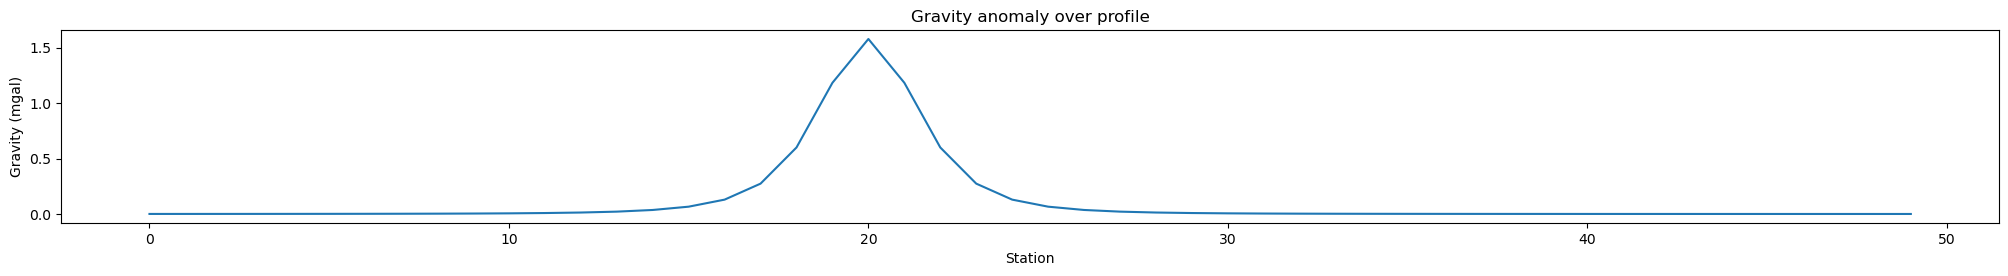

In [78]:
# Plot the values of d_est using PyPlot
fig = figure(figsize=(length/2,depth/2))
plot(d_est)
xlabel("Station")
ylabel("Gravity (mgal)")
title("Gravity anomaly over profile")
show()

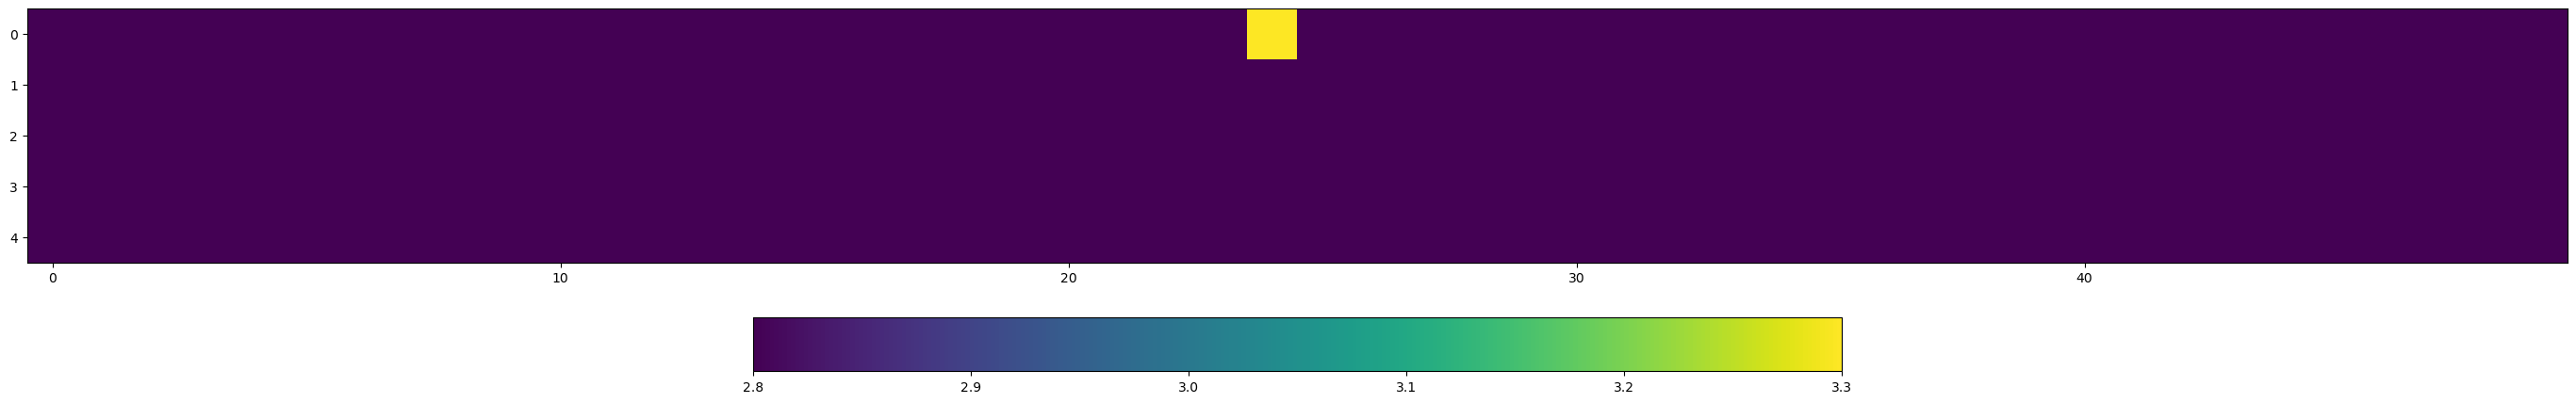

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff87cd7ac80>

In [79]:
fig = figure(figsize=(length,depth))
imshow(model .+ background)
colorbar(orientation="horizontal")

In [95]:
d_obs = d_est

#SET PARAMETERS
ζ = 1e-4;
β = 1.00; ε = 1e-12;
ITERATIONS=1;

#***SHOULD NOT NEED TO EDIT BELOW THIS LINE***

# fix for reproducability
Random.seed!(44); println("Random Seed No. '",randstring(),"'\n") 

#get dimensions
M = size(model)[1] * size(model)[2];
N = size(model)[2];

# generate a G with assuming no change in datum height (z)
G = generateKernel(M, zeros(N), x, z);

g_obs = vcat(ones(20) * 4, d_obs);  #zero pad for stability
g_obs = d_obs

#make an H matrix "flatness"
H = Matrix{Float64}(I,M,M) * -1; #smoothness matrix
for i = 1:M-1, j = 2:M
    H[i,i+1] = 1;
    #H[j,j-1] = 1;
end

# make A matrix [G]
############## [H]

A = hcat(G', ζ * H')';

# make a P matrix ("hard constraint")
P = Matrix{Float64}(I, M, M);

#make a Q matrix ("depth weighting matrix")
Q = Matrix{Float32}(I, M, M);


for j = 1:M
    Q_jj = 1 / (((j*z) + ε)^β);
    Q[j,:] = Q[j,:] * Q_jj;
end

# make a V matrix ("compactness")
𝓥 = Matrix{Float64}(I,M,M); #initially set to Identity

Random Seed No. 'F4IiX48W'

(kernel.jl) the model is 5 by 50

250×250 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [96]:
#set any initial density estimates
# ρ_back = ones(M) * background
ρ_back = zeros(M)

ρ = Array{Float64}(undef,M) .+ ρ_back;
ρ_min = 0;
ρ_max = 3;

null_vector = zeros(M)

for i = 1:M #update hard constraint
    if ρ[i] != 2.5
        P[i,i] = 1e-2
    end
end

In [97]:
for i = 1:ITERATIONS
    W = inv(P) * Q * 𝓥
    g_cal = G * ρ
    b = vcat(g_obs - g_cal, null_vector);
    Θ = return_m((A * inv(W)) * transpose((A * inv(W))), b, 40); # C.G.

    global ρ = ρ + (inv(W) * transpose(A * inv(W)) * Θ)

    for j = 1:M
        𝓥[j,j] = 1 / ((ρ[j])^2 + 1e-11)
        if ρ[j] < ρ_min || ρ[j] > ρ_max
            P[j,j] = 1e-2
        else
            P[j,j] = 1
        end
    end
end

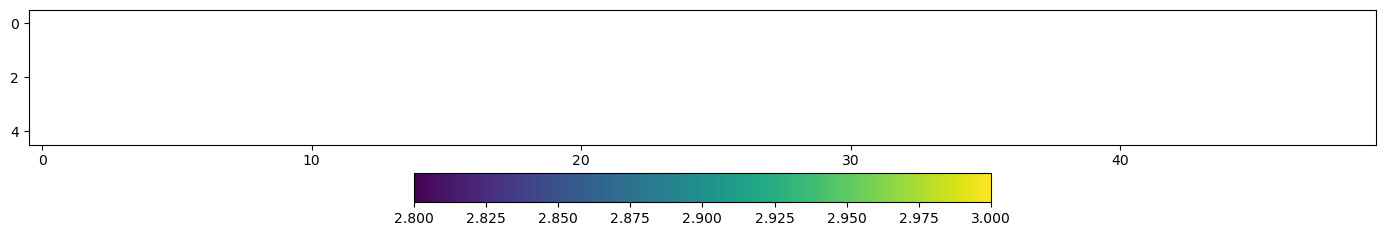

PyObject <matplotlib.colorbar.Colorbar object at 0x7ff866ecf100>

In [98]:
model_est = reshape(ρ, (length, depth)) .+ background

fig = figure(figsize=(length/2,depth/2))
imshow(transpose(model_est) , vmin=2.8, vmax=3)
colorbar(orientation="horizontal")
# npzwrite("m_est.npy", model_est) #write out to a numpy file

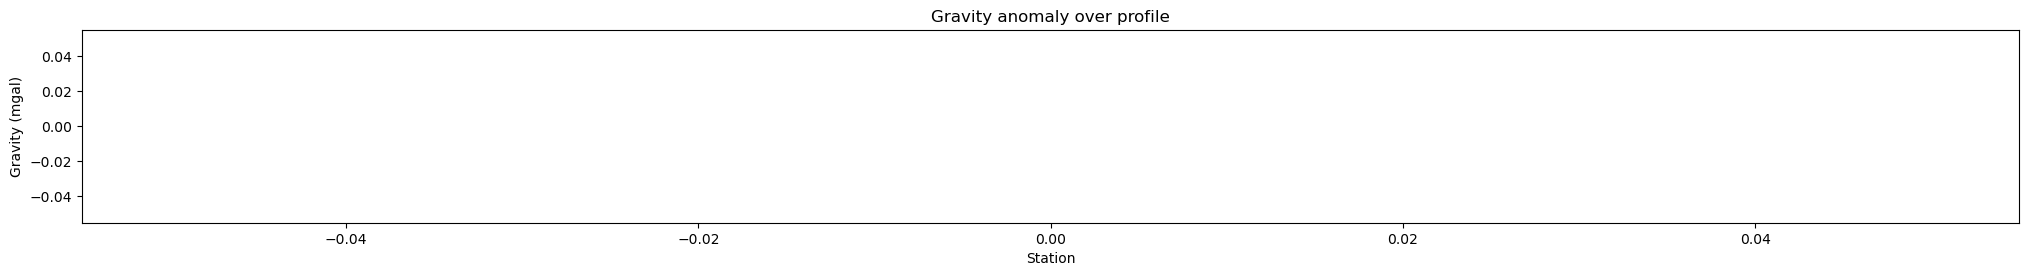

In [99]:
d_estf = G * ρ
# Plot the values of d_est using PyPlot
fig = figure(figsize=(length/2,depth/2))

plot(d_estf)
xlabel("Station")
ylabel("Gravity (mgal)")
title("Gravity anomaly over profile")
show()